# CatBoost (GBDT) experiments (Example).

Import dependencies.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

from preprocessors.preprocessor import Preprocessor

from preprocessors.scalers.min_max_scaler import MinMaxScalerData
from preprocessors.scalers.log_increases_scaler import LogIncreasesScalerData

from models.catboost.union_catboost import UnionCatBoost
from models.catboost.multi_catboost import MultiCatBoost, GreedyMultiCatBoost

from models.catboost.catboost_evaluator import Evaluator as CatBoostEvaluator

from preprocessors.extrapolate_functions import *

from utils import mape, rmse
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr as pearson

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

In [2]:
DATA_PATH = "../data/BRDT_1997.csv"
train_size = 7475
val_size = 551
max_train_horizons = 55
max_prediction_horizons = 30
d_size = 4

In [3]:
df = pd.read_csv(DATA_PATH)

Let's get a small glipse on the data. EUCRBRDT Comdty is the target column, information form Date column is not obtained during training.

In [4]:
df.head()

,EUCRBRDT Comdty,RUB CBRF Curncy,EURUSD Curncy,Date
0,24.37,5.554,1.2713,1/2/97
1,24.27,5.554,1.2577,1/3/97
2,24.27,5.554,1.2577,1/4/97
3,24.27,5.554,1.2577,1/5/97
4,24.73,5.554,1.2516,1/6/97


Let's try to use MinMaxScalerData with linear piecewise extrapolation to see, what happens.

In [5]:
scaler=MinMaxScalerData(train_size=train_size)

preprocessor = Preprocessor(
    dataset=df.iloc[:, :].to_numpy(),
    max_pred_horizon=max_prediction_horizons,
    max_train_horizon=max_train_horizons,
    d_size=d_size,
    extrapolator_x=x_linear_piecewise,
    extrapolator_y=y_linear_piecewise,
)

Using cpu


In [6]:
preprocessor.train_val_test_split(
    train_size=train_size,
    val_size=val_size,
    scaler=scaler,
    use_tqdm=True,
)

100%|██████████| 414/414 [00:00<00:00, 3044.00it/s]


In [7]:
test_size = preprocessor.x_test.shape[0]

print('Test size:', test_size)

Test size: 415


Check the plot for each row.

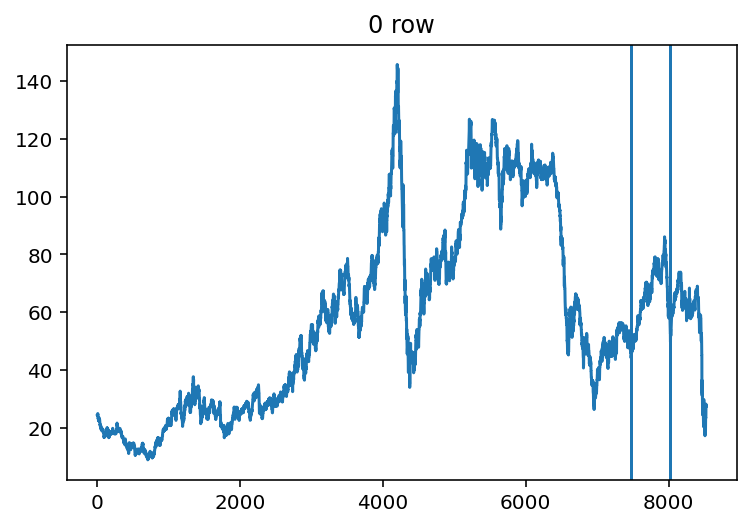

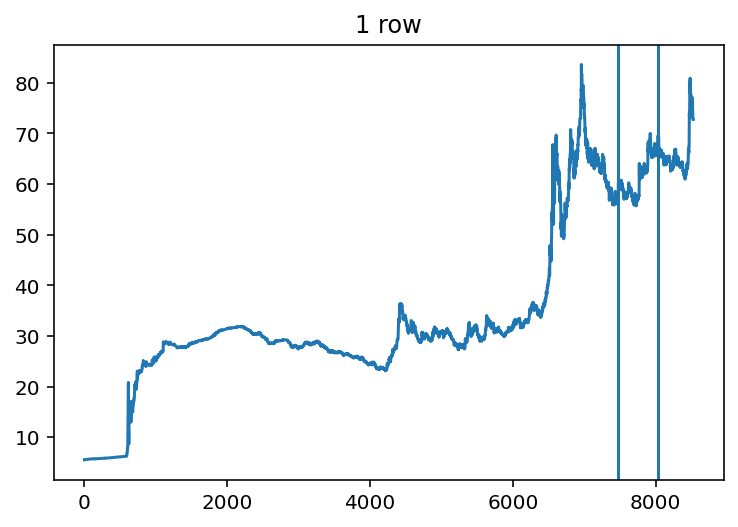

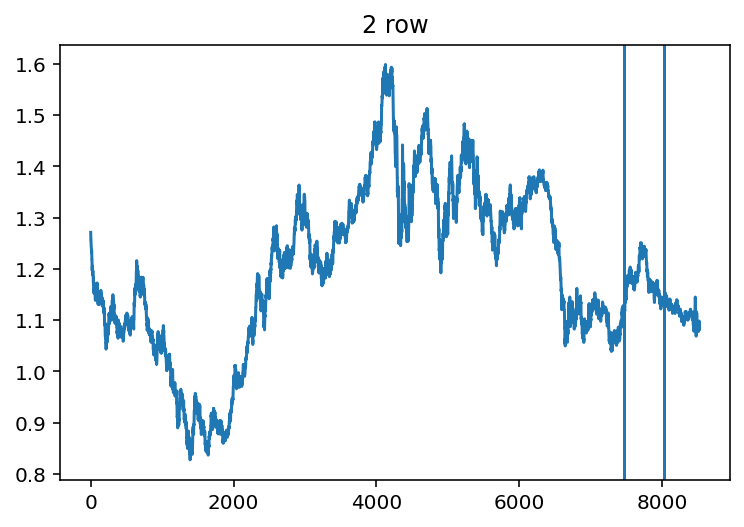

In [8]:
for row_ind in range(d_size - 1):
    preprocessor.plot_row(row=row_ind)

Let's try to predict MEAN.

In [9]:
params = {
    'regressor': UnionCatBoost,
    'preprocessor': preprocessor,
    'function_x_train': lambda x: x.reshape(train_size, -1),
    'function_y_train': lambda y: y[:, :, 0].mean(axis=-1),
    'function_x_val': lambda x: x.reshape(val_size, -1),
    'function_y_val': lambda y: y[:, :, 0].mean(axis=-1),
    'function_x_test': lambda x: x.reshape(test_size, -1),
    'function_y_test': lambda y: y[:, :, 0].mean(axis=-1),
    'train_horizons': [9, 11],
    'prediction_horizons': [7, 14, 21],
    'metric': rmse,
    'metric_name': 'RMSE',
    'loss_function': 'RMSE',
    'grid_search_params': {
        'verbose': [3500],
        'has_time': [True],
        'iterations': [3500],
    },
    'use_gpu': False,
}

In [10]:
rmse_union_catboost_eval_linear_big = CatBoostEvaluator(**params)

rmse_union_catboost_eval_linear_big.evaluate_params()

rmse_union_catboost_eval_linear_big.form_result_table(
    metric_names=['MAE', 'RMSE', 'MAPE', 'pearson'],
    metrics=[mean_absolute_error, rmse, mape, pearson],
    part='test',
    is_real_data=True,
)

Train_horizon: 9
Prediction_horizon: 7
Estimator params: {'verbose': 3500, 'has_time': True, 'iterations': 3500}
Learning rate set to 0.030878
0:	learn: 0.2413405	test: 0.0895357	best: 0.0895357 (0)	total: 89.2ms	remaining: 5m 12s
3499:	learn: 0.0043897	test: 0.0196126	best: 0.0187233 (146)	total: 1m 28s	remaining: 0us

bestTest = 0.01872325956
bestIteration = 146

Shrink model to first 147 iterations.
(551, 1)
(551,)
Best shift: 8
Best estimator params: {'verbose': 3500, 'has_time': True, 'iterations': 3500}
Train_horizon: 9
Prediction_horizon: 14
Estimator params: {'verbose': 3500, 'has_time': True, 'iterations': 3500}
Learning rate set to 0.030878
0:	learn: 0.2411512	test: 0.0891994	best: 0.0891994 (0)	total: 20.7ms	remaining: 1m 12s
3499:	learn: 0.0046280	test: 0.0296166	best: 0.0235130 (126)	total: 1m 12s	remaining: 0us

bestTest = 0.02351301895
bestIteration = 126

Shrink model to first 127 iterations.
(551, 1)
(551,)
Best shift: 11
Best estimator params: {'verbose': 3500, 'has_t

[          7         14        21
 9   1.500873  1.986457  2.630428
 11  1.159080  1.505398  1.982842,
           7         14        21
 9   1.656135  2.119563  2.809226
 11  1.421831  1.692446  2.212655,
           7         14        21
 9   2.744164  3.579741  4.678326
 11  2.226033  2.728752  3.569732,
                            7                          14  \
 9   (0.9968194226714656, 0.0)  (0.9959179389444526, 0.0)   
 11  (0.9927057854463711, 0.0)  (0.9939648784776438, 0.0)   
 
                            21  
 9    (0.990744476751153, 0.0)  
 11  (0.9896160129371596, 0.0)  ]

Let's have a look on the prediction (train_horizon=11, pred_horizon=14). Vertical lines devide each part of the dataset (train. val and test) from each ither.

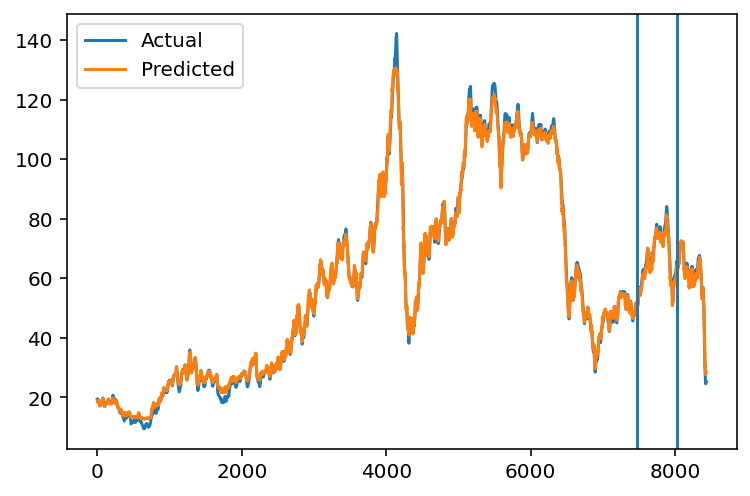

In [11]:
#Linear

rmse_union_catboost_eval_linear_big.plot_union(
    train_horizon=11,
    pred_horizon=14,
    start_ind=0,
    end_ind=None,
)

Closer look.

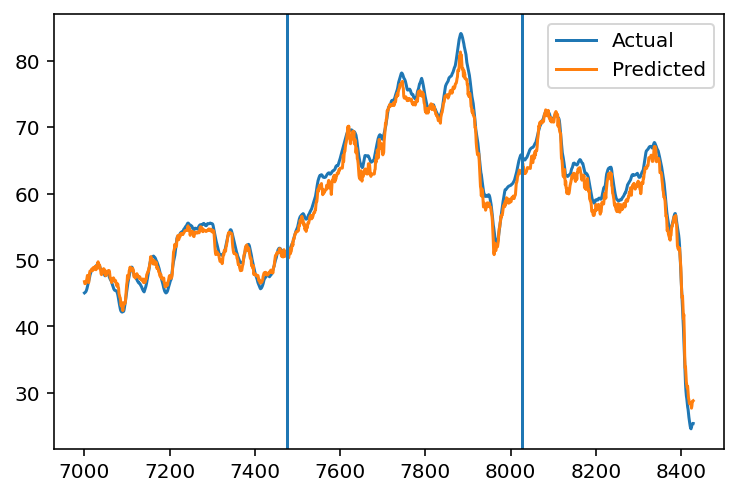

In [12]:
#Linear

rmse_union_catboost_eval_linear_big.plot_union(
    train_horizon=11,
    pred_horizon=14,
    start_ind=7000,
    end_ind=None,
)

Note: others targets (min and max) can be easily predicted by changing the fuction_x_... in the cell above.

Let's try to deal with multi-target output.

Let's use MultiRMSE - the only loss-function, supported for honest multi-target output in GBDT.

In [13]:
mae_multi_catboost_eval = CatBoostEvaluator(
    regressor=MultiCatBoost,
    preprocessor=preprocessor,
    function_x_train=lambda x: x.reshape(train_size, -1),
    function_y_train=lambda y: y[:, :, 0],
    function_x_val=lambda x: x.reshape(val_size, -1),
    function_y_val=lambda y: y[:, :, 0],
    function_x_test=lambda x: x.reshape(test_size, -1),
    function_y_test=lambda y: y[:, :, 0],
    train_horizons=[14],
    prediction_horizons=[7, 14],
    metric=mean_absolute_error,
    metric_name='MAE',
    loss_function='MultiRMSE',
    grid_search_params={
        'verbose': [500],
        'has_time': [True],
        'iterations': [5000],
    },
    use_gpu=False,
)

In [14]:
mae_multi_catboost_eval.evaluate_params()

Train_horizon: 14
Prediction_horizon: 7
Estimator params: {'verbose': 500, 'has_time': True, 'iterations': 5000}
0:	learn: 1.1178824	test: 1.1175557	best: 1.1175557 (0)	total: 70.8ms	remaining: 5m 53s
500:	learn: 0.0374467	test: 0.0929519	best: 0.0922857 (484)	total: 22.3s	remaining: 3m 20s
1000:	learn: 0.0295080	test: 0.0903158	best: 0.0900189 (920)	total: 1m 2s	remaining: 4m 8s
1500:	learn: 0.0253175	test: 0.0885650	best: 0.0885650 (1500)	total: 1m 42s	remaining: 4m
2000:	learn: 0.0223796	test: 0.0882260	best: 0.0882104 (1997)	total: 2m 8s	remaining: 3m 13s
2500:	learn: 0.0201987	test: 0.0882672	best: 0.0881206 (2092)	total: 2m 30s	remaining: 2m 29s
3000:	learn: 0.0184690	test: 0.0870962	best: 0.0870613 (2956)	total: 2m 47s	remaining: 1m 51s
3500:	learn: 0.0170249	test: 0.0870515	best: 0.0866825 (3206)	total: 3m 18s	remaining: 1m 24s
4000:	learn: 0.0158191	test: 0.0865914	best: 0.0864997 (3957)	total: 4m 4s	remaining: 1m 1s
4500:	learn: 0.0147779	test: 0.0865024	best: 0.0864807 (4484

In [15]:
mae_multi_catboost_eval.form_result_table(
    metric_names=['MAE'],
    metrics=[mean_absolute_error],
    part='test',
    is_real_data=False,
)

Loss function: MultiRMSE
Metric: MAE
          7         14
14  0.018522  0.023743
_____________________


[          7         14
 14  0.018522  0.023743]

Let's have a look on the prediction of out model. The vertical line divides train data from the predicted values on them.

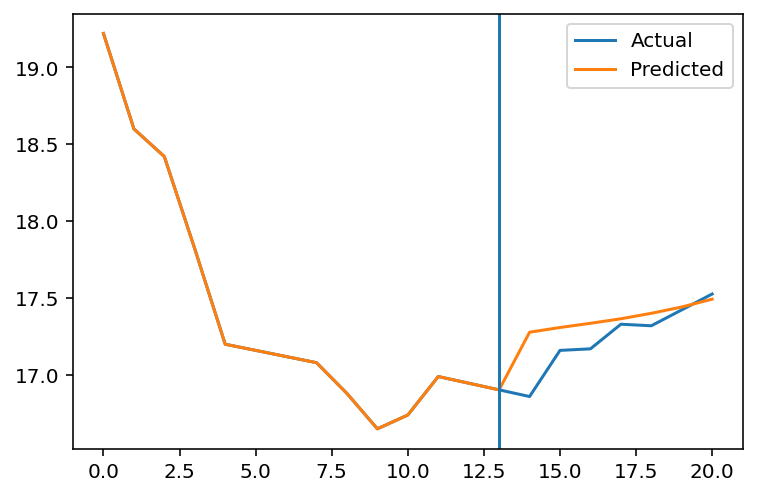

In [21]:
mae_multi_catboost_eval.plot_multi(
    train_horizon=14,
    pred_horizon=7,
    start_ind=110,
)